In [1]:
!pip install catboost

     |████████████████████████████████| 66.1MB 53kB/s 


In [82]:
import csv
from bs4 import BeautifulSoup
import requests
import re
from tqdm import tqdm
from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_squared_log_error

pd.set_option('display.max_rows', 500)
sns.set(rc={'figure.figsize':(12,10)})

# Data Gathering

In [ ]:
base_url = "https://www.property24.com"
headers = {'User-Agent': 'Mozilla/5.0'}

In [ ]:
for p in range(1,399):
    url = "https://www.property24.com/for-sale/cape-town/western-cape/432/p{}?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse".format(p)
    
    print("Scraping page {} : {}".format(p,url))
    page = requests.get(url, headers=headers)

    soup = BeautifulSoup(page.text, 'html.parser')
    blocks = soup.find_all("div", {"class":"js_rollover_container"})

    result = []
    for b in blocks:
        list_link = b.find_all("a")
        for l in list_link:
            result.append(l["href"])

    links = [base_url + l for l in set(result)]
    links = list(set([l.split("?", 1)[0] for l in links]))

    filename = "/content/drive/My Drive/property24/page{}.csv".format(p)
    with open(filename, 'w') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(links)

Scraping page 1 : https://www.property24.com/for-sale/cape-town/western-cape/432/p1?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 2 : https://www.property24.com/for-sale/cape-town/western-cape/432/p2?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 3 : https://www.property24.com/for-sale/cape-town/western-cape/432/p3?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 4 : https://www.property24.com/for-sale/cape-town/western-cape/432/p4?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 5 : https://www.property24.com/for-sale/cape-town/western-cape/432/p5?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 6 : https://www.property24.com/for-sale/cape-town/western-cape/432/p6?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 7 : https://www.property24.com/for-sale/cape-town/western-cape/432/p7?PropertyCategory=House%2cApartmentOrFlat%2cTownhouse
Scraping page 8 : https://www.property24.

In [ ]:
links_file = "/content/drive/My Drive/property24/property24links.csv"
with open(links_file,"a") as out:
    for p in range(1,399):
        for line in open("/content/drive/My Drive/property24/page{}.csv".format(p)):
            out.write(line)

In [ ]:
links_file = "/content/drive/My Drive/property24/property24links.csv"
houses_links = []
with open(links_file) as myfile:
    reader = csv.reader(myfile)
    for line in reader:
        for link in line:
            houses_links.append(link)

In [ ]:
data = pd.DataFrame()
skipped = []
for url in tqdm(houses_links[:2700]):
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    try:
        features = {}
        main_feature_names = ["Listing Number", "Type of Property", "Listing Date", "Erf Size", "Floor Size"]
        for f in main_feature_names:
            feature_value = soup.find("div",string=f)
            if feature_value is not None:
                feature_value = feature_value.findNext("div", {"class":"p24_info"}).text
                features[f] = feature_value

        features["Price"] = soup.find("input", {"class":"form-control"})["value"]
        features["Town"] = soup.find("div",{"class":"p24_mB"}).text.strip()
        list_features = soup.find_all("div", {"class":"p24_listingFeatures"})
        for f in list_features:
            feature_name = f.find("span", {"class":"p24_feature"}).text.replace(':','')
            feature_value = f.find("span", {"class":"p24_featureAmount"})
            if feature_value is not None:
                feature_value = float(feature_value.text)
            else:
                feature_value = 1
            features[feature_name] = feature_value
        data = data.append(features, ignore_index=True)
    except (AttributeError,KeyError):
        print(url)
        skipped.append(url)


 21%|██▏       | 576/2700 [24:03<1:36:20,  2.72s/it]

https://www.property24.com/for-sale/kirstenhof/cape-town/western-cape/10178/109027929



 35%|███▍      | 941/2700 [39:13<1:27:29,  2.98s/it]

https://www.property24.com/for-sale/costa-da-gama/cape-town/western-cape/13856/109148260



 47%|████▋     | 1277/2700 [53:17<1:11:31,  3.02s/it]

https://www.property24.com/for-sale/plumstead/cape-town/western-cape/10094/109043796



 48%|████▊     | 1300/2700 [54:15<1:05:23,  2.80s/it]

https://www.property24.com/for-sale/observatory/cape-town/western-cape/10157/108867073



100%|██████████| 2700/2700 [1:52:23<00:00,  2.50s/it]


In [ ]:
data.to_csv("/content/drive/My Drive/property24-0-2700.csv")

data1 = pd.read_csv("/content/drive/My Drive/property24-0-2700.csv")
data2 = pd.read_csv("/content/drive/My Drive/property24-2700-5200.csv")
data3 = pd.read_csv("/content/drive/My Drive/property24-5200-end.csv")

final_data =  pd.concat([data1,data2,data3])
final_data = final_data.drop(["Unnamed: 0"], axis=1)
final_data.to_csv("/content/drive/My Drive/property24_data.csv", index=False)

In [ ]:
# Get Suburb names in Cape Town
url = "https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs"
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.text, 'html.parser')

suburb_dict = {}
suburb_list = []

tables = soup.find_all("table", {"class":"wikitable"})
for t in tables:
    suburb_group = t.find_previous_sibling('h2').find("span").text
    suburb = []
    for row in t.findAll('tr'):
        td = row.findAll('td')
        if td:
            s = td[0].text
            s = re.sub(r'\([^)]*\)', '', s) # remove parentheses
            s = s.strip()
            suburb.append(s)
            suburb_list.append(s)
    suburb_dict[suburb_group] = suburb

# Data Cleaning

In [83]:
data = pd.read_csv("/content/drive/My Drive/property24_data.csv", index_col="Listing Number")

In [84]:
no_price_index = list(data[data["Price"].isnull()].index)
corrupt_data_index = [108948813,108987998,108765912,108524737,108560520,108689532,108973493]

data = data.drop(no_price_index + corrupt_data_index)
data["Listing Date"] = pd.to_datetime(data["Listing Date"])

data["Town"] = data["Town"].str.replace(", Cape Town","").str.split(",").str[-1]
data["Town"] = data["Town"].str.strip()
data.loc[data["Town"].str.contains("City Centre"), "Town"] = "City Centre"

data.loc[data["Town"].str.contains("Kenilworth Upper"), "Town"] = "Kenilworth"
data["Town"] = data["Town"].str.replace("Upper","").str.strip()
data["Town"] = data["Town"].str.replace("Bo Kaap","Bo-Kaap").str.strip()
data["Town"] = data["Town"].str.replace("Marina Da Gama","Marina da Gama").str.strip()

counts = data["Town"].value_counts()
data = data[~data["Town"].isin(counts[counts < 10].index)]

data["Erf Size"].fillna(data["Floor Size"], inplace=True)
data["Floor Size"].fillna(data["Erf Size"], inplace=True)
data["Erf Size"] = data["Erf Size"].str.replace("m²","").str.replace(" ","").str.strip().astype("float")
data["Floor Size"] = data["Floor Size"].str.replace("m²","").str.replace(" ","").str.strip().astype("float")

data["Garages"].fillna(0, inplace=True)
data["Garden"].fillna(0, inplace=True)
data["Pool"].fillna(0, inplace=True)
data["Bedrooms"].fillna(0, inplace=True)

data["No Pets Allowed"].fillna(0, inplace=True)

data["Parking"].fillna(data["Secure Parking"], inplace=True)
data["Parking"].fillna(0, inplace=True)

data["Furnished"].fillna(data["Furnished (Optional)"], inplace=True)
data["Furnished"].fillna(0, inplace=True)

data["Flatlet"].fillna(0, inplace=True)

data["Fibre Internet"].fillna("", inplace=True)
data["ADSL Internet"].fillna("", inplace=True)
data["Satellite Internet"].fillna("", inplace=True)
data["Fibre Internet"].replace(1,"Fibre", inplace=True)
data["ADSL Internet"].replace(1,"ADSL", inplace=True)
data["Satellite Internet"].replace(1,"Sattelite", inplace=True)
data["Internet"] = data["Fibre Internet"] + data["ADSL Internet"] + data["Satellite Internet"] 
data["Internet"].replace("","None", inplace=True)

drop_columns=["Pet Friendly","Fibre Internet","Secure Parking","Furnished (Optional)",
              "ADSL Internet","Satellite Internet","Fixed WiMax Internet"]
data.drop(drop_columns, axis=1, inplace=True)

data["Garages"] = data["Garages"].astype("int")
data["Bedrooms"] = data["Bedrooms"].astype("int")
data["Parking"] = data["Parking"].astype("int")
data["Garden"] = data["Garden"].astype("int")
data["Pool"] = data["Pool"].astype("int")
data["No Pets Allowed"] = data["No Pets Allowed"].astype("int")
data["Furnished"] = data["Furnished"].astype("int")
data["Flatlet"] = data["Flatlet"].astype("int")

In [54]:
#data.to_csv("/content/drive/My Drive/clean_property24_data.csv")

In [85]:
X = data.drop(["Price"], axis=1)
y = data["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Exploratory Data Analysis

In [86]:
X_train.tail()

,Bathrooms,Bedrooms,Erf Size,Floor Size,Garages,Listing Date,Town,Type of Property,Garden,Pool,Parking,No Pets Allowed,Furnished,Flatlet,Internet
Listing Number,,,,,,,,,,,,,,,
108533391,3.00,3,496.00,496.00,2,2020-03-05,Claremont,House,1,0,0,0,0,0,None
107759452,2.00,2,92.00,92.00,0,2019-07-29,City Centre,Apartment / Flat,0,0,1,1,0,0,None
108144150,1.00,2,81.00,81.00,0,2019-11-07,Foreshore,Apartment / Flat,0,1,0,0,1,0,None
108990780,5.00,5,"1,120.00",420.00,2,2020-08-15,Rondebosch,House,1,1,0,0,0,0,None
108553294,1.00,0,41.00,41.00,1,2020-03-10,City Centre,Apartment / Flat,0,0,0,0,0,0,None


In [88]:
y_train.describe()

count         6,104.00
mean      5,744,681.04
std       8,107,821.48
min         199,000.00
25%       1,850,000.00
50%       2,995,000.00
75%       5,995,000.00
max     172,500,000.00
Name: Price, dtype: float64

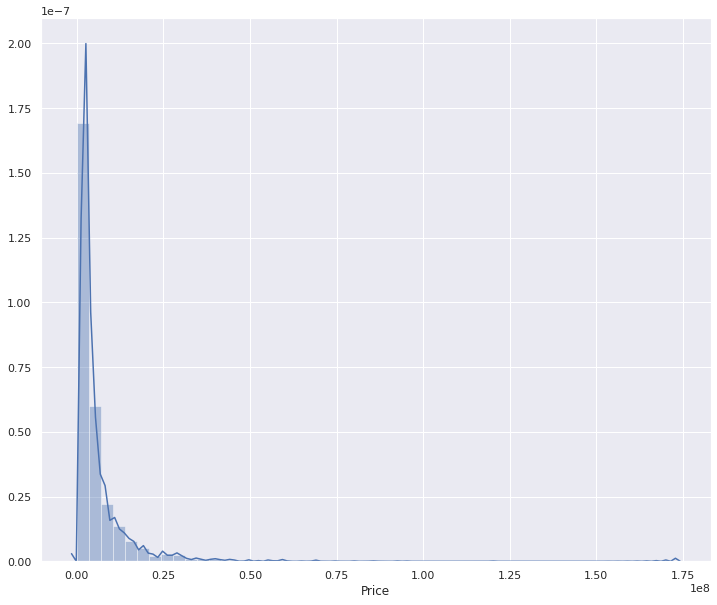

In [89]:
sns.distplot(y_train)

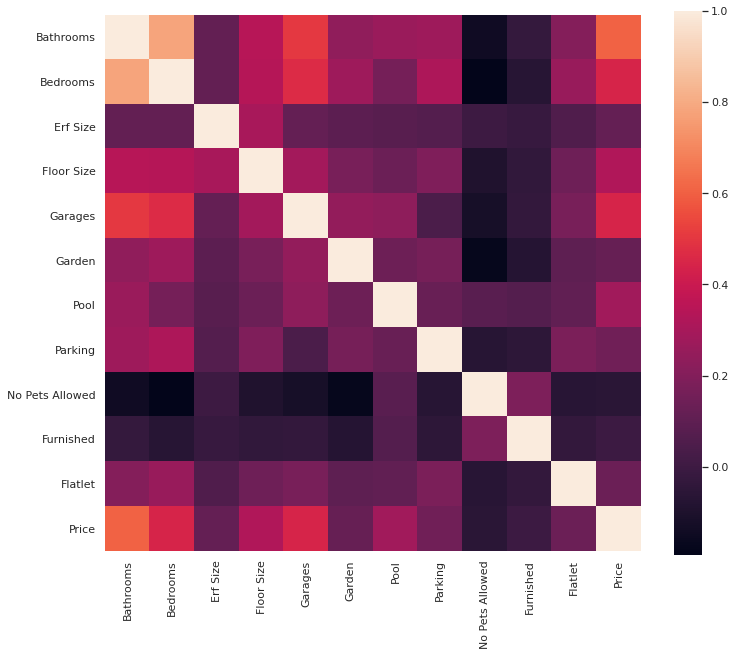

In [90]:
corrmat = pd.concat([X_train,y_train],axis=1).corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, square=True);

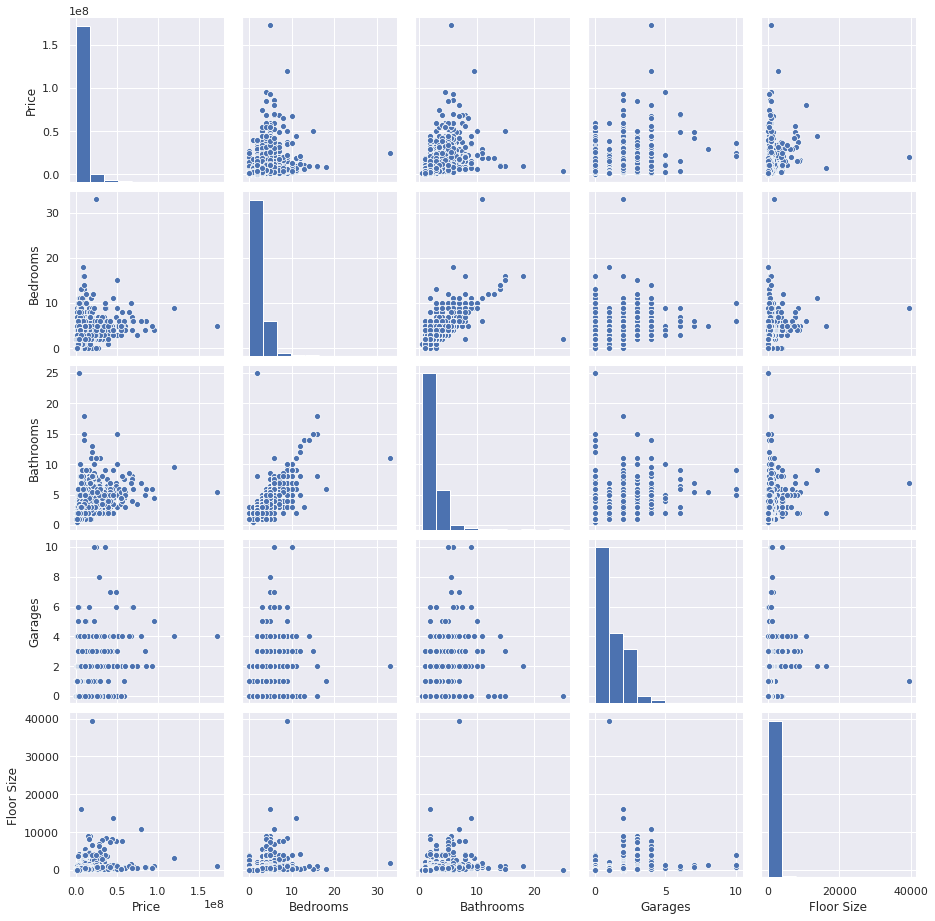

In [91]:
sns.set()
cols = ['Price', 'Bedrooms', 'Bathrooms', 'Garages', 'Floor Size']
sns.pairplot(pd.concat([X_train,y_train],axis=1)[cols])

In [96]:
X_test["Bedrooms"]

Listing Number
109087868    2
109073114    3
109091503    1
108268260    1
107377779    6
            ..
108376274    8
108822939    2
109068226    3
108899774    2
108577855    4
Name: Bedrooms, Length: 1527, dtype: int64

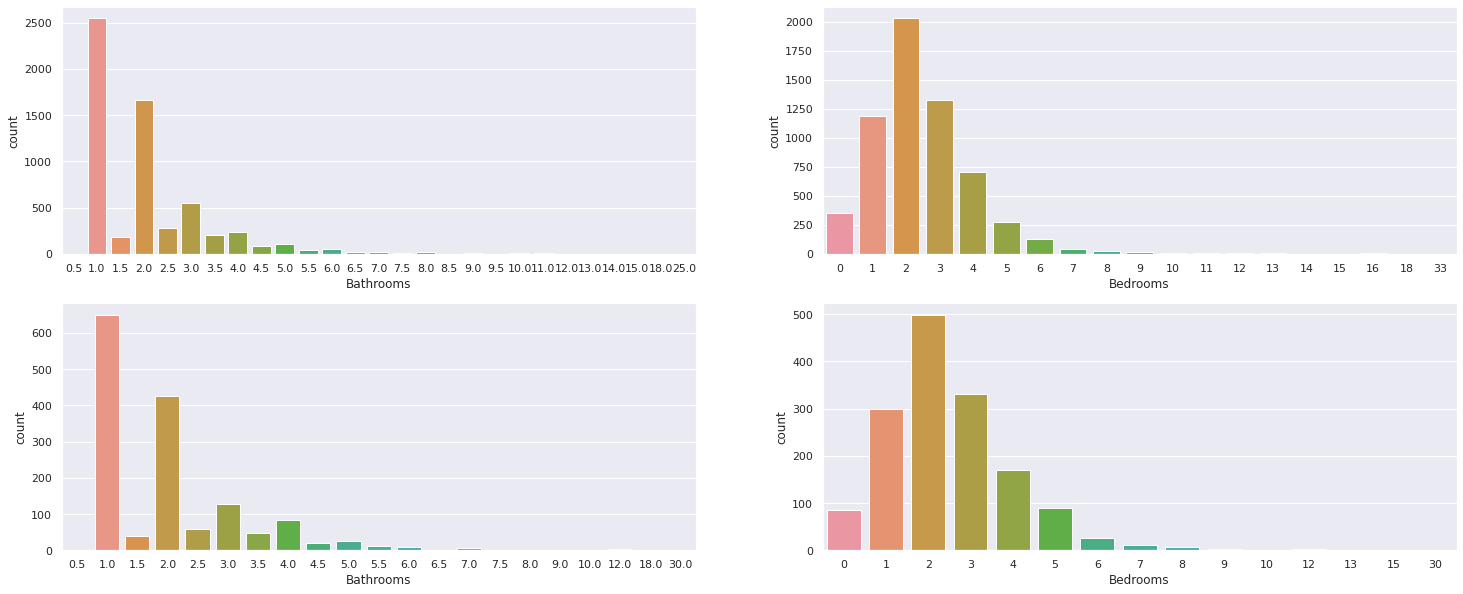

In [108]:
fig, axs = plt.subplots(2,2 ,figsize=(25,10))
sns.countplot(x="Bathrooms", data=X_train, ax=axs[0,0])
sns.countplot(x="Bedrooms", data=X_train, ax=axs[0,1])

sns.countplot(x="Bathrooms", data=X_test, ax=axs[1,0])
sns.countplot(x="Bedrooms", data=X_test, ax=axs[1,1])

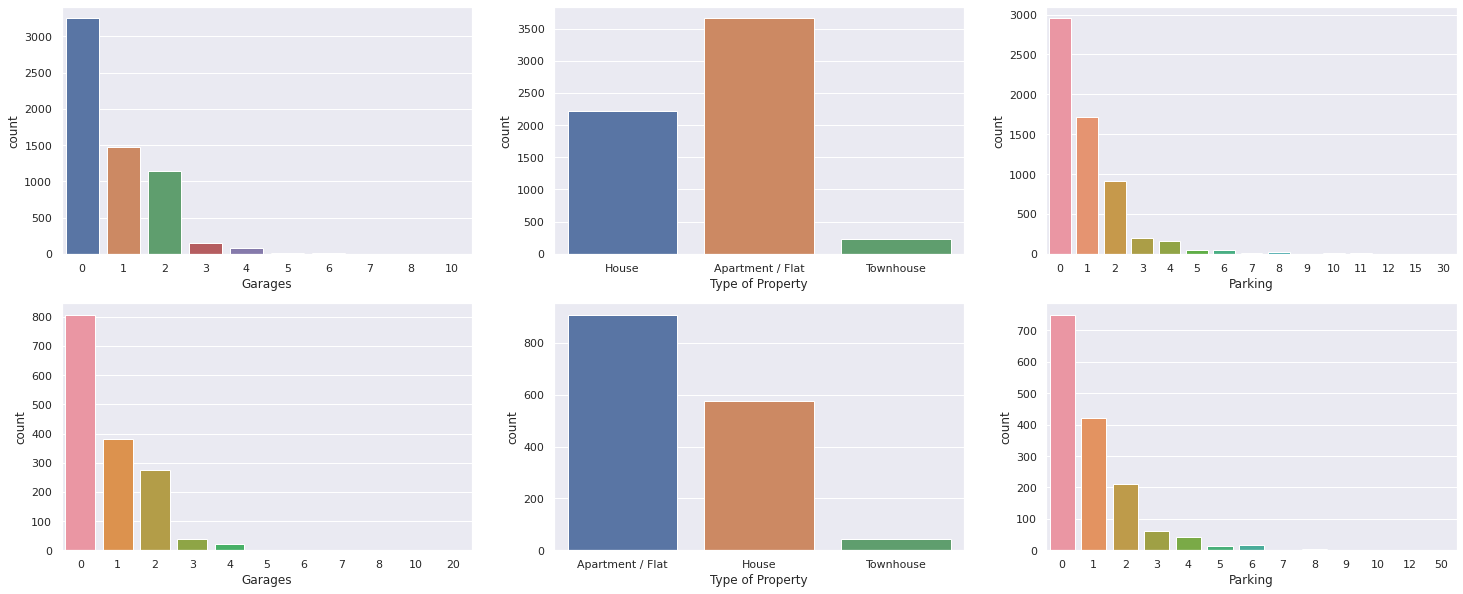

In [102]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.countplot(x="Garages", data=X_train, ax=axs[0,0])
sns.countplot(x="Type of Property", data=X_train, ax=axs[0,1])
sns.countplot(x="Parking", data=X_train, ax=axs[0,2])

sns.countplot(x="Garages", data=X_test, ax=axs[1,0])
sns.countplot(x="Type of Property", data=X_test, ax=axs[1,1])
sns.countplot(x="Parking", data=X_test, ax=axs[1,2])

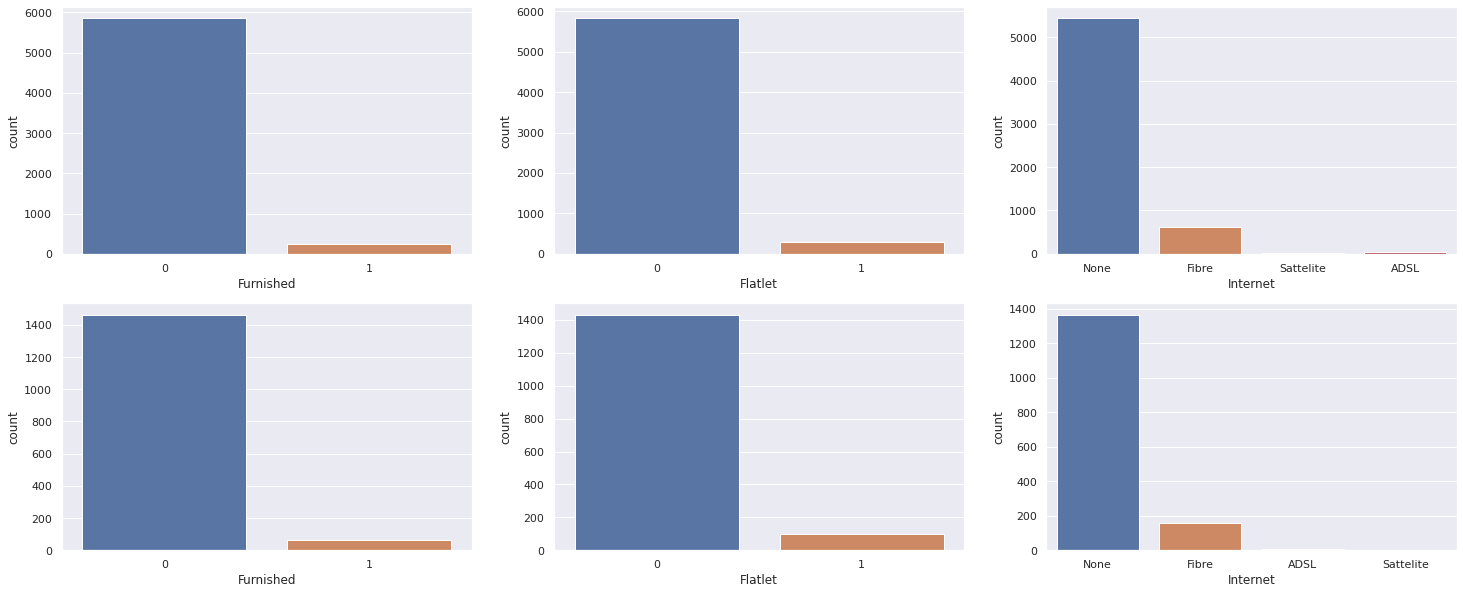

In [109]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.countplot(x="Furnished", data=X_train, ax=axs[0,0])
sns.countplot(x="Flatlet", data=X_train, ax=axs[0,1])
sns.countplot(x="Internet", data=X_train, ax=axs[0,2])

sns.countplot(x="Furnished", data=X_test, ax=axs[1,0])
sns.countplot(x="Flatlet", data=X_test, ax=axs[1,1])
sns.countplot(x="Internet", data=X_test, ax=axs[1,2])

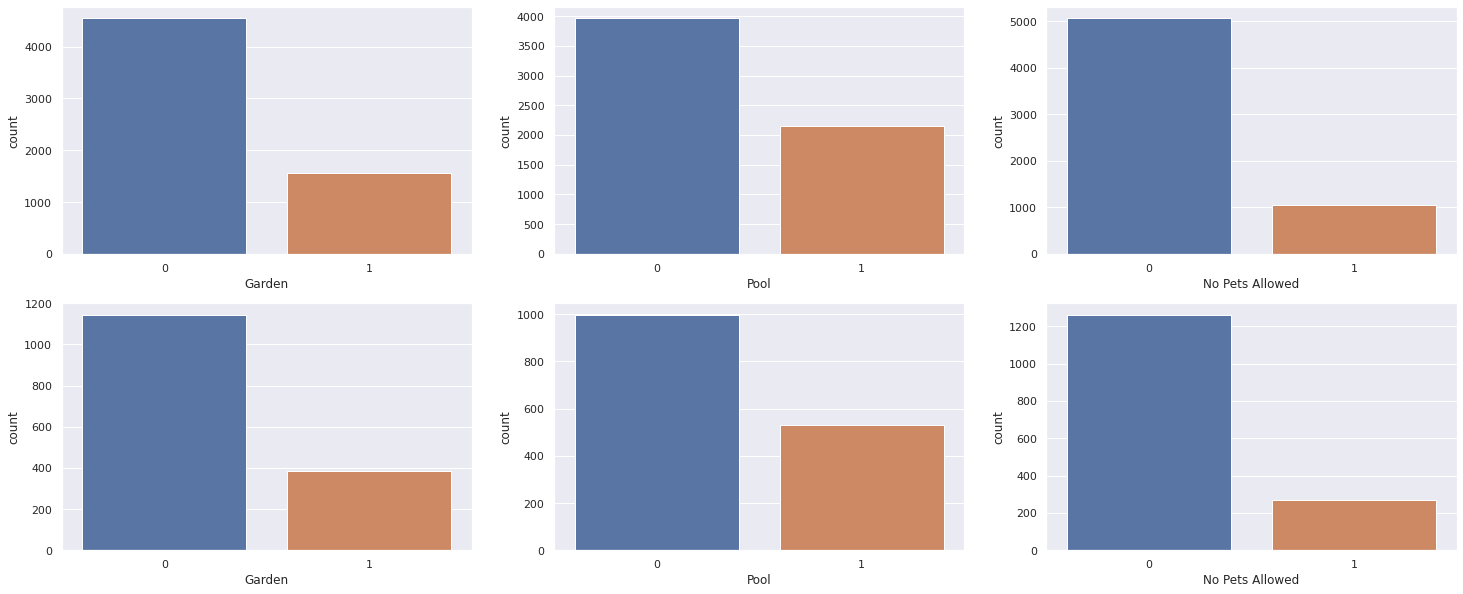

In [111]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.countplot(x="Garden", data=X_train, ax=axs[0,0])
sns.countplot(x="Pool", data=X_train, ax=axs[0,1])
sns.countplot(x='No Pets Allowed', data=X_train, ax=axs[0,2])

sns.countplot(x="Garden", data=X_test, ax=axs[1,0])
sns.countplot(x="Pool", data=X_test, ax=axs[1,1])
sns.countplot(x='No Pets Allowed', data=X_test, ax=axs[1,2])

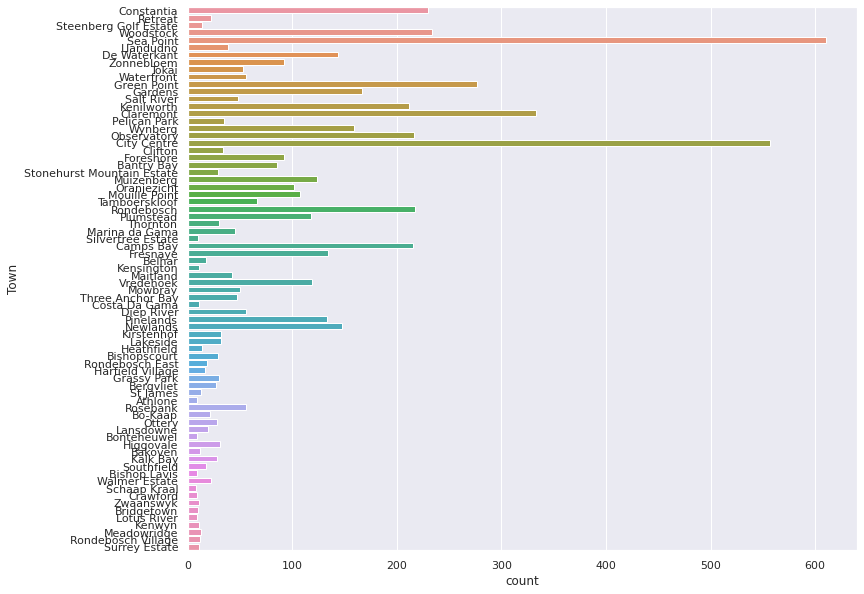

In [117]:
sns.countplot(y="Town", data=X_train)

# Preprocessing

In [57]:
# Convert string date to seconds
X_train.loc[:,'Listing Date'] = X_train['Listing Date'].dt.strftime('%d/%m/%Y')
X_test.loc[:,'Listing Date'] = X_test['Listing Date'].dt.strftime('%d/%m/%Y')
X_train.loc[:,'Listing Date'] = X_train['Listing Date'].apply(lambda d: time.mktime (time.strptime(str(d), "%d/%m/%Y")) if str(d) !='nan' else float('nan'))
X_test.loc[:,'Listing Date'] = X_test['Listing Date'].apply(lambda d: time.mktime (time.strptime(str(d), "%d/%m/%Y")) if str(d) !='nan' else float('nan'))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
numerical_cols = ["Bathrooms","Bedrooms","Erf Size","Floor Size","Garages","Listing Date"]
categorical_cols= ["Town","Type of Property","Garden", "Pool","Parking","No Pets Allowed","Furnished","Flatlet","Internet"]

In [59]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [60]:
combined_data = pd.concat([X_train, X_test])

label_encoder = LabelEncoder()
for col in categorical_cols:
    combined_data.loc[:,col] = label_encoder.fit_transform(combined_data.loc[:,col])

combined_data[numerical_cols] = numeric_transformer.fit_transform(combined_data[numerical_cols])

X_train_transformed = combined_data[:X_train.shape[0]]
X_test_transformed = combined_data[-X_test.shape[0]:]

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_train_transformed, y_train, test_size=0.1, random_state=2)

In [62]:
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_val)
mean_squared_error(y_val, y_pred)

0.39307485549568283

In [45]:
ridge = Ridge()
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_val)
mean_squared_error(y_val, y_pred)

0.39305712979566754

In [44]:
ridge = Ridge(alpha=1.5)
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_val)
mean_squared_error(y_val, y_pred)

0.39304830814230884

In [42]:
svr = SVR()
svr.fit(X_train,y_train)
y_pred = svr.predict(X_val)
mean_squared_error(y_val, y_pred)

0.35596973066501564

In [41]:
svr = SVR(kernel='rbf', gamma="auto")
svr.fit(X_train,y_train)
y_pred = svr.predict(X_val)
mean_squared_error(y_val, y_pred)

0.19395787008559226

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_val)
mean_squared_error(y_val, y_pred)

[18:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1573224790831262

In [ ]:
catb = CatBoostRegressor()
catb.fit(X_train,y_train,categorical_cols)
y_pred = catb.predict(X_val)
mean_squared_error(y_val, y_pred)

Learning rate set to 0.052855
0:	learn: 0.8731417	total: 8.41ms	remaining: 8.4s
1:	learn: 0.8503032	total: 12.1ms	remaining: 6.05s
2:	learn: 0.8214420	total: 19.4ms	remaining: 6.43s
3:	learn: 0.7953190	total: 26.6ms	remaining: 6.63s
4:	learn: 0.7705824	total: 33.7ms	remaining: 6.71s
5:	learn: 0.7462904	total: 39.6ms	remaining: 6.56s
6:	learn: 0.7235302	total: 46ms	remaining: 6.53s
7:	learn: 0.7016290	total: 51.7ms	remaining: 6.42s
8:	learn: 0.6816436	total: 58.2ms	remaining: 6.41s
9:	learn: 0.6633149	total: 64.8ms	remaining: 6.41s
10:	learn: 0.6458998	total: 71.8ms	remaining: 6.45s
11:	learn: 0.6289354	total: 78.5ms	remaining: 6.47s
12:	learn: 0.6133667	total: 85.2ms	remaining: 6.47s
13:	learn: 0.5984919	total: 91.5ms	remaining: 6.45s
14:	learn: 0.5848330	total: 98.5ms	remaining: 6.46s
15:	learn: 0.5723782	total: 106ms	remaining: 6.49s
16:	learn: 0.5605872	total: 113ms	remaining: 6.51s
17:	learn: 0.5496018	total: 119ms	remaining: 6.5s
18:	learn: 0.5389649	total: 128ms	remaining: 6.59s


0.0828852760908512

In [ ]:
parameters={'alpha':np.linspace(1,1.5, 50)}
grid = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=5,n_jobs=-1,verbose=1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.5, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.        , 1.01020408, 1.02040816, 1.03061224, 1.04081633,
       1.05102041, 1.06122449, 1.07142857, 1.08163265, 1.09183673,
       1.10204082, 1.1122449 , 1.1224489...
       1.25510204, 1.26530612, 1.2755102 , 1.28571429, 1.29591837,
       1.30612245, 1.31632653, 1.32653061, 1.33673469, 1.34693878,
       1.35714286, 1.36734694, 1.37755102, 1.3877551 , 1.39795918,
       1.40816327, 1.41836735, 1.42857143, 1.43877551, 1.44897959,
       1.45918367, 1.46938776, 1.47959184, 1.48979592, 1.5       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid.best_score_, grid.best_params_

(-0.37782370186504, {'alpha': 1.5})

In [38]:
catb = CatBoostRegressor()
grid = {'learning_rate': [0.03, 0.1, 0.3, 0.2],
        'depth': [3, 3.5, 4, 4.5],
        'l2_leaf_reg': [1, 2, 3]}

grid_search_result = catb.grid_search(grid, 
                                       X_train, 
                                       y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3944032113
bestIteration = 999

0:	loss: 0.3944032	best: 0.3944032 (0)	total: 1.3s	remaining: 1m 1s

bestTest = 0.3341861214
bestIteration = 999

1:	loss: 0.3341861	best: 0.3341861 (1)	total: 2.46s	remaining: 56.5s

bestTest = 0.3288187215
bestIteration = 938

2:	loss: 0.3288187	best: 0.3288187 (2)	total: 3.66s	remaining: 54.9s

bestTest = 0.3264752194
bestIteration = 999

3:	loss: 0.3264752	best: 0.3264752 (3)	total: 4.84s	remaining: 53.2s

bestTest = 0.4019031154
bestIteration = 999

4:	loss: 0.4019031	best: 0.3264752 (3)	total: 5.98s	remaining: 51.4s

bestTest = 0.3346517678
bestIteration = 999

5:	loss: 0.3346518	best: 0.3264752 (3)	total: 7.14s	remaining: 50s

bestTest = 0.3209466701
bestIteration = 998

6:	loss: 0.3209467	best: 0.3209467 (6)	total: 8.31s	remaining: 48.7s

bestTest = 0.3260013124
bestIteration = 999

7:	loss: 0.3260013	best: 0.3209467 (6)	total: 9.47s	remaining: 47.4s

bestTest = 0.4052731984
bestIteration = 999

8:	loss: 0.4052732	best: 0.3209467 (6

In [39]:
grid_search_result

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [40]:
params = {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.3}
catb = CatBoostRegressor(**params)
catb.fit(X_train,y_train,categorical_cols)
y_pred = catb.predict(X_val)
mean_squared_error(y_val, y_pred)

0:	learn: 0.7660229	total: 3.93ms	remaining: 3.92s
1:	learn: 0.6741561	total: 7.81ms	remaining: 3.9s
2:	learn: 0.5803573	total: 11ms	remaining: 3.67s
3:	learn: 0.5299228	total: 14.4ms	remaining: 3.58s
4:	learn: 0.4946144	total: 17.3ms	remaining: 3.44s
5:	learn: 0.4689628	total: 21.1ms	remaining: 3.49s
6:	learn: 0.4505789	total: 24.6ms	remaining: 3.49s
7:	learn: 0.4374210	total: 28ms	remaining: 3.48s
8:	learn: 0.4274688	total: 31.1ms	remaining: 3.42s
9:	learn: 0.4185845	total: 34.6ms	remaining: 3.43s
10:	learn: 0.4104939	total: 37.9ms	remaining: 3.4s
11:	learn: 0.4052962	total: 40.1ms	remaining: 3.3s
12:	learn: 0.4019863	total: 43.9ms	remaining: 3.33s
13:	learn: 0.3988452	total: 47.1ms	remaining: 3.32s
14:	learn: 0.3931495	total: 50ms	remaining: 3.29s
15:	learn: 0.3909542	total: 53.1ms	remaining: 3.26s
16:	learn: 0.3893729	total: 56.8ms	remaining: 3.29s
17:	learn: 0.3872534	total: 59.5ms	remaining: 3.25s
18:	learn: 0.3836158	total: 62ms	remaining: 3.2s
19:	learn: 0.3807941	total: 65ms	r

0.08643186665344425

# Tesing

In [63]:
X_train_full = pd.concat([X_train,X_val])
y_train_full = pd.concat([y_train, y_val])

In [64]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_full,y_train_full)
y_pred = lin_reg.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

0.4144801336231493

In [66]:
ridge = Ridge()
ridge.fit(X_train_full,y_train_full)
y_pred = ridge.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

0.41447680709398327

In [67]:
ridge = Ridge(alpha=1.5)
ridge.fit(X_train_full,y_train_full)
y_pred = ridge.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

0.41447515421727354

In [69]:
svr = SVR()
svr.fit(X_train_full,y_train_full)
y_pred = svr.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

0.35513981047069726

In [70]:
svr = SVR(kernel='rbf', gamma="auto")
svr.fit(X_train_full,y_train_full)
y_pred = svr.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

0.1831025976147635

In [71]:
xgb = XGBRegressor()
xgb.fit(X_train_full,y_train_full)
y_pred = xgb.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

[09:19:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.16079392259841027

In [73]:
catb = CatBoostRegressor()
catb.fit(X_train_full,y_train_full,categorical_cols)
y_pred = catb.predict(X_test_transformed)
mean_squared_error(y_test, y_pred)

Learning rate set to 0.053857
0:	learn: 0.8670696	total: 9.04ms	remaining: 9.03s
1:	learn: 0.8369386	total: 15.8ms	remaining: 7.9s
2:	learn: 0.8087441	total: 23.2ms	remaining: 7.72s
3:	learn: 0.7815553	total: 30.1ms	remaining: 7.49s
4:	learn: 0.7553983	total: 38.4ms	remaining: 7.64s
5:	learn: 0.7320552	total: 44.6ms	remaining: 7.38s
6:	learn: 0.7081681	total: 51.2ms	remaining: 7.26s
7:	learn: 0.6865766	total: 58.2ms	remaining: 7.22s
8:	learn: 0.6657506	total: 65.1ms	remaining: 7.17s
9:	learn: 0.6479315	total: 72.7ms	remaining: 7.2s
10:	learn: 0.6305387	total: 80.8ms	remaining: 7.27s
11:	learn: 0.6151214	total: 88.8ms	remaining: 7.31s
12:	learn: 0.5995328	total: 98.3ms	remaining: 7.46s
13:	learn: 0.5850805	total: 107ms	remaining: 7.56s
14:	learn: 0.5718986	total: 115ms	remaining: 7.58s
15:	learn: 0.5605391	total: 122ms	remaining: 7.51s
16:	learn: 0.5491042	total: 129ms	remaining: 7.48s
17:	learn: 0.5386130	total: 136ms	remaining: 7.43s
18:	learn: 0.5281938	total: 144ms	remaining: 7.42s


0.08442679469534982